# Exploring Clevr-Kiwi

In [17]:
import json
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread
import numpy as np

Before starting, download the train-val zip and the metadata zip and extract them in some folder of your choosing, e.g. so that you have something like `./some_folder/train-val` and `./some_folder/metadata`.

The Clevr-Kiwi dataset is structured similarly to that of the original Clevr. If we look in the `train-val` folder (I have simply extracted it so that it's in my `/tmp` directory), we can see a whole bunch of subfolders with indices. These indices don't carry any meaning and were simply byproducts of generating the dataset in parallel over our cluster. Essentially, each subfolder is a batch of scenes and questions, and all of the indices together comprise the entire dataset.

Let us examine one of these indices.

In [7]:
%%bash
ls /tmp/train-val/290

images
questions.json
scenes
scenes.json


Let's open up the `scenes.json` file

In [10]:
scenes = json.loads(open("/tmp/train-val/290/scenes.json").read())

In [11]:
scenes.keys()

dict_keys(['scenes', 'info'])

In [15]:
len(scenes['scenes']) # there are 100 scenes per index

100

Each scene consists of 20 cameras, randomly sampled in a 360 degree arc with constant altitude. `cc` refers to the 'canonical camera', which is what the corresponding questions (in `questions.json`) are with respect to.

In [26]:
scenes['scenes'][0].keys()

dict_keys(['cam17', 'cam3', 'cam13', 'cam11', 'cam7', 'cam5', 'cam16', 'cc', 'cam2', 'cam8', 'cam15', 'cam4', 'cam14', 'cam9', 'cam10', 'cam1', 'cam0', 'cam19', 'cam18', 'cam6', 'cam12'])

Let us visualise a random subset (16) of these cameras

In [46]:
cam_names = list(scenes['scenes'][0].keys())
np.random.shuffle(cam_names)

In [47]:
cam_names_subset = list(cam_names)[0:16]
cam_names_subset

['cam0',
 'cam16',
 'cam10',
 'cam11',
 'cam3',
 'cam17',
 'cam4',
 'cam19',
 'cam8',
 'cam12',
 'cam14',
 'cam6',
 'cam18',
 'cam15',
 'cam7',
 'cam5']

In [70]:
scenes['scenes'][0][ cam_names_subset[j] ]['image_filename']

'CLEVR_train-clevr-kiwi-spatial_s029000_cam5.png'

We can see that image filenames are of the form `CLEVR_train-clevr-kiwi-spatial_sX_Y.jpg`, where `X` is a unique scene identifier and `Y` denotes the camera number. If `Y` is `cc`, this means it is the canonical camera.

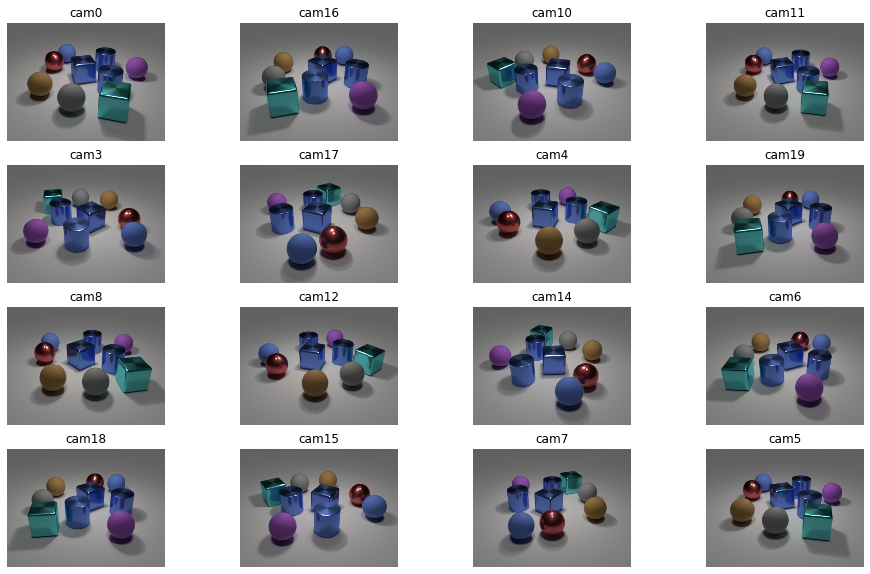

In [59]:
plt.figure(figsize=(16,10))
plt.tight_layout()
for j in range(16):
    plt.subplot(4,4,j+1)
    img = imread("/tmp/train-val/290/images/%s" % \
                 scenes['scenes'][0][ cam_names_subset[j] ]['image_filename'].replace(".png",".jpg"))
    plt.imshow(img)
    plt.axis('off')
    plt.title(cam_names_subset[j])

**Please note that:** due to a bug in the dataset generation script for this manuscript submission, there are no small objects in any of the scenes. While this does not invalidate the proposed dataset and experimental results (because the primary contribution of the dataset lies in doing VQA from random viewpoints), we do plan to fix this and release that version as v2.

In [60]:
img_canonical = imread("/tmp/train-val/290/images/%s" % \
                 scenes['scenes'][0]['cc']['image_filename'].replace(".png",".jpg"))

Here is the canonical camera. While the canonical camera is fixed to the same position (i.e. same world 3d coordinates) for every scene in the dataset, in principle it should not be able to be easily determined by eyeballing the images, since we made an effort to ensure that there were no landmarks in the dataset (e.g. directional lighting) that could give hints as to what its position is. In other words, unless you have the 3d coordinates of the camera pertaining to the image, it should not be possible to determine the canonical camera's coordinates.

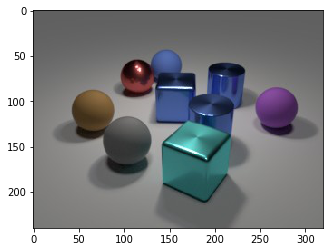

In [87]:
plt.imshow(img_canonical)

Let's load some questions for this scene.

In [62]:
questions = json.loads(open("/tmp/train-val/290/questions.json").read())

In [64]:
questions.keys()

dict_keys(['info', 'questions'])

In [74]:
q1['image_filename']

'CLEVR_train-clevr-kiwi-spatial_s029000_cc.png'

In [77]:
%%bash
open /tmp/train-val/290/images/CLEVR_train-clevr-kiwi-spatial_s029000_cc.jpg

In [71]:
q1 = questions['questions'][0]
q1['question']

'Are there the same number of large gray objects that are left of the gray thing and big matte cylinders?'

In [72]:
q1['answer']

True

In [86]:
for question in questions['questions']:
    if "CLEVR_train-clevr-kiwi-spatial_s029000" in question['image_filename']:
        print("Q:", question['question'])
        print("  A:", question['answer'])

Q: Are there the same number of large gray objects that are left of the gray thing and big matte cylinders?
  A: True
Q: Is the number of large brown things that are behind the red thing less than the number of purple objects?
  A: True
Q: Are there more blue blocks to the left of the large gray thing than blue matte spheres?
  A: False
Q: Are there an equal number of big brown things that are in front of the large brown rubber ball and big metal things that are behind the purple sphere?
  A: False
Q: Is the number of red shiny spheres to the right of the purple rubber sphere less than the number of blue matte objects that are on the right side of the blue block?
  A: False
Q: Is the number of blue blocks left of the large gray ball greater than the number of blocks to the left of the big red metal ball?
  A: False
Q: Does the thing that is behind the red metal ball have the same size as the metal ball?
  A: True
Q: Does the gray matte ball have the same size as the metallic block that

Just to verify things, I'm going to do a human evaluation of the first couple of questions.

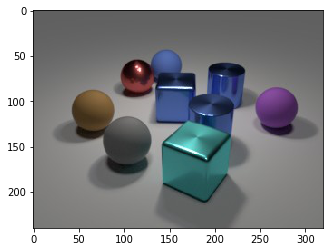

In [88]:
plt.imshow(img_canonical)

**Q: Are there the same number of large gray objects that are left of the gray thing and big matte cylinders?**

A: Yes, which is zero, because there are no large grey objects to the left of the grey thing (== 0)
and there are also no big matte cylinders (== 0), so 0 == 0.

**Q: Is the number of large brown things that are behind the red thing less than the number of purple objects?**

A: Yes, since 0 < 1. There is a brown object but it's in front of the red thing, not BEHIND it.

**Q: Are there more blue blocks to the left of the large gray thing than blue matte spheres?**

A: No, there are no blue blocks to the left of the large gray thing, but there is one blue matt sphere.

**Q: Is the number of blue blocks left of the large gray ball greater than the number of blocks to the left of the big red metal ball?**

A: No, because there are no blue blocks left of the grey ball (==0) and also no blocks to the left of the big red metal ball (==0).

## Loading data in PyTorch

Below is an example Dataset class that can be used in conjunction with FILM. This class will use the metadata that's in the H5 files. Just to keep things quick, I am going to instead load the valid set, since it has a much smaller metadata footprint and won't clog up our RAM as much.

In [26]:
import glob
import h5py
import os
from PIL import Image

In [11]:
CAM_NAMES = []
for j in range(0,19+1):
    CAM_NAMES.append("cam" + str(j))
CAM_NAMES.append("cc")

# Courtesy of: https://github.com/ethanjperez/film
def invert_dict(d):
    return {v: k for k, v in d.items()}

# Courtesy of: https://github.com/ethanjperez/film
def load_vocab(path):
    with open(path, 'r') as f:
        vocab = json.load(f)
        vocab['question_idx_to_token'] = invert_dict(vocab['question_token_to_idx'])
        #vocab['program_idx_to_token'] = invert_dict(vocab['program_token_to_idx'])
        vocab['answer_idx_to_token'] = invert_dict(vocab['answer_token_to_idx'])
    # Sanity check: make sure <NULL>, <START>, and <END> are consistent
    assert vocab['question_token_to_idx']['<NULL>'] == 0
    assert vocab['question_token_to_idx']['<START>'] == 1
    assert vocab['question_token_to_idx']['<END>'] == 2
    #assert vocab['program_token_to_idx']['<NULL>'] == 0
    #assert vocab['program_token_to_idx']['<START>'] == 1
    #assert vocab['program_token_to_idx']['<END>'] == 2
    return vocab

class ClevrKiwiDataset(Dataset):
    def __init__(self,
                 root_images,
                 root_meta,
                 transforms_=None,
                 mode='train',
                 canonical_only=False):
        """
        root_images: root directory for images
        root_meta: root directory for metadata
        max_subfolders: this is only here for
          the sake of this notebook: to speed
          up the instantiation of the class,
          otherwise we'd be loading a ton of
          metadata into memory.
        transforms_: a list of torchvision transforms
        mode: either 'train', 'val', or 'test'
        canonical_only: if `True`, only output
         canonical views.
        """

        subfolders = glob.glob("%s/*" % root_images)

        self.root_images = root_images
        self.root_meta = root_meta
        self.transform = transforms.Compose(transforms_)
        self.canonical_only = canonical_only

        self.vocab = load_vocab("%s/vocab.json" % root_meta)

        if mode not in ['train', 'val', 'test']:
            raise Exception("mode must be either train or val or test (got %s)" % mode)
        self.mode = mode

        # This holds every question and for all intents
        # and purposes is the _length_ of this dataset.
        # In order to map a question to its scene we
        # must parse its filename and use id_to_scene
        # in order to go from question to camera views.
        if mode == 'train':
            h5 = h5py.File("%s/train_questions.h5" % root_meta, "r")
        elif mode == 'val':
            h5 = h5py.File("%s/valid_questions.h5" % root_meta, "r")
        else:
            h5 = h5py.File("%s/test_questions.h5" % root_meta, "r")

        self.answers = h5['answers'][:]
        self.image_filenames = [ x.decode('utf-8') for x in h5['image_filenames'][:] ]
        self.template_filenames = [x.decode('utf-8') for x in h5['template_filenames'][:] ]
        self.questions = h5['questions'][:]
        self.question_strs = h5['question_strs'][:]

        assert len(self.answers) == len(self.image_filenames) == len(self.questions)

        # Construct an internal dictionary, `id_to_scene`, which
        # maps from a scene id to the scene metadata.
        id_to_scene = {}
        n_questions = 0
        for subfolder in subfolders:
            q_file = "%s/questions.json" % subfolder
            s_file = "%s/scenes.json" % subfolder

            if not os.path.exists(q_file) or not os.path.exists(s_file):
                print("ERROR: skip:", subfolder)
                continue

            q_json = json.loads(open(q_file).read())
            s_json = json.loads(open(s_file).read())

            n_questions += len(q_json['questions'])

            # Collect scenes first.
            for idx, scene in enumerate(s_json['scenes']):
                # Add subfolder to scene dict
                for key in scene:
                    scene[key]['subfolder'] = os.path.basename(subfolder)

                this_scene_cc = scene['cc']
                # e.g. 's002400'
                this_basename = this_scene_cc['image_filename'].split("_")[-2]
                # Map the basename e.g. s002400
                # to its dictionary of camera views.
                id_to_scene[this_basename] = scene

        self.id_to_scene = id_to_scene
        self.mode = mode

    def __getitem__(self, index):
        # Ok, grab the metadata
        this_q = torch.from_numpy(self.questions[index]).long()
        this_answer = torch.LongTensor([self.answers[index]])
        this_filename_cc = self.image_filenames[index]
        this_id = this_filename_cc.split("_")[-2]
        this_template_filename = self.template_filenames[index]

        # A dictionary of keys consisting of camera
        # views.
        scene_from_id = self.id_to_scene[this_id]
        subfolder = scene_from_id['cc']['subfolder']
        
        if self.canonical_only:
            cam_names = ["cc"]
        else:
            cam_names = CAM_NAMES
        
        # Select a random camera, this will be image 1
        rnd_cam_name = cam_names[ np.random.randint(0, len(cam_names)) ]
        img_filename = this_filename_cc.replace("_cc", "_"+rnd_cam_name).\
            replace(".png", ".jpg")
        this_img_path = "%s/%s/images/%s" % \
            (self.root_images, subfolder, img_filename)

        img = Image.open(this_img_path).convert('RGB')
        img = self.transform(img)

        # Select a random camera, this will be image 2.
        rnd_cam_name2 = cam_names[ np.random.randint(0, len(cam_names)) ]
        img_filename2 = this_filename_cc.replace("_cc", "_"+rnd_cam_name2).\
            replace(".png", ".jpg")
        this_img_path2 = "%s/%s/images/%s" % \
            (self.root_images, subfolder, img_filename2)
        img2 = Image.open(this_img_path2).convert('RGB')
        img2 = self.transform(img2)

        # Get camera coordinates of image 1.
        this_cam = torch.FloatTensor(
            scene_from_id[rnd_cam_name]['cam_params'])

        # Get camera coordinates of image 2.
        this_cam2 = torch.FloatTensor(
            scene_from_id[rnd_cam_name2]['cam_params'])

        return img, img2, this_q, this_cam, this_cam2, this_answer

    def __len__(self):
        return len(self.questions)


In [22]:
# setting max_subfolders=20 just to speed up
# dataset creation.
ds = ClevrKiwiDataset(root_images="/tmp/train-val", 
                      root_meta="/tmp/metadata",
                      mode='val',
                      transforms_=[
                          transforms.Resize((224,224)),
                          transforms.ToTensor()
                      ])

In [23]:
# The length of the dataset is how many questions. 
# There are roughly ~10 questions per scene.
len(ds)

24977

In [24]:
loader = DataLoader(ds, batch_size=8, shuffle=True)

In [35]:
for x1, x2, q, cam1, cam2, answer in loader:
    break

In [36]:
x1.shape, x2.shape

(torch.Size([8, 3, 224, 224]), torch.Size([8, 3, 224, 224]))

In [37]:
q.shape

torch.Size([8, 45])

In [40]:
cam1.shape, cam2.shape

(torch.Size([8, 6]), torch.Size([8, 6]))

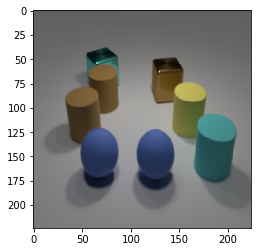

In [46]:
# view 1
plt.imshow(x1[0].numpy().swapaxes(0,1).swapaxes(1,2))

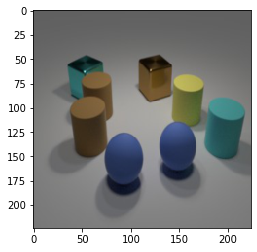

In [48]:
# view 2
plt.imshow(x2[0].numpy().swapaxes(0,1).swapaxes(1,2))